In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [4]:
train_path = '../input/symptoms/Numerical Dataset/Training.csv'
test_path = '../input/symptoms/Numerical Dataset/Testing.csv'

In [5]:
train_df = pd.read_csv(train_path)

In [ ]:
train_df

In [19]:
train_df.dtypes

test_date              object
cough                   int64
fever                   int64
sore_throat             int64
shortness_of_breath     int64
head_ache               int64
age_60_and_above       object
gender                 object
test_indication        object
corona_result           int64
dtype: object

In [6]:
test_df = pd.read_csv(test_path)

In [7]:
train_size = train_df.size
test_size = test_df.size

In [8]:
target = 'corona_result'

In [ ]:
train_split = 0.9
val_split = 1-train_split

In [ ]:
train_only_size = int(train_split * train_size)
val_only_size = int(val_split * train_size)

In [ ]:
#train_only_df, val_only_df = np.split(train_df.sample(frac=1),[int(train_split*len(train_df))])

In [ ]:
#train_only_df.to_csv("train.csv",index=False)
#val_only_df.to_csv("valid.csv",index=False)

In [9]:
train_only_path = '../input/symptomscsv9010/train.csv'
valid_only_path = '../input/symptomscsv9010/valid.csv'

In [14]:
import seaborn as sns

<AxesSubplot:xlabel='gender', ylabel='Count'>

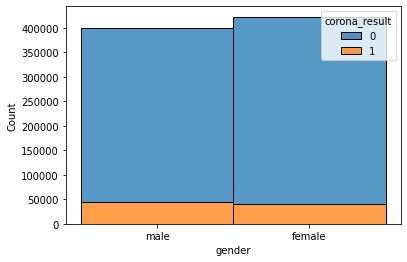

In [26]:
sns.histplot(x='gender',hue='corona_result',data=train_df,stat="count", multiple="stack")

<AxesSubplot:xlabel='cough', ylabel='Count'>

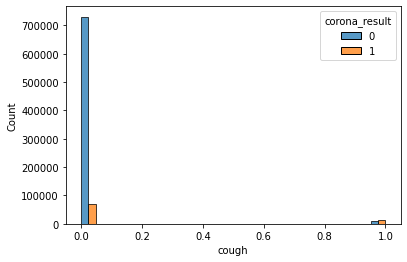

In [28]:
sns.histplot(x='cough',hue='corona_result',data=train_df,stat="count", multiple="dodge")

<AxesSubplot:xlabel='fever', ylabel='Count'>

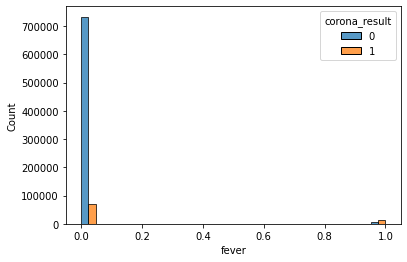

In [29]:
sns.histplot(x='fever',hue='corona_result',data=train_df,stat="count", multiple="dodge")

<AxesSubplot:xlabel='sore_throat', ylabel='Count'>

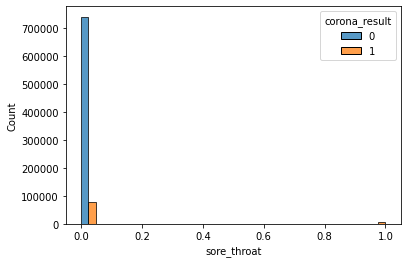

In [30]:
sns.histplot(x='sore_throat',hue='corona_result',data=train_df,stat="count", multiple="dodge")

<AxesSubplot:xlabel='shortness_of_breath', ylabel='Percent'>

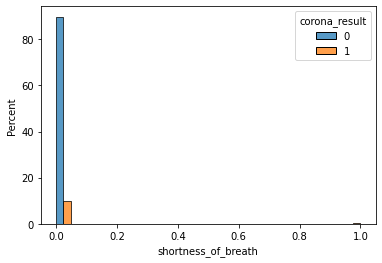

In [35]:
sns.histplot(x='shortness_of_breath',hue='corona_result',data=train_df,stat="percent", multiple="dodge")

<AxesSubplot:xlabel='head_ache', ylabel='Percent'>

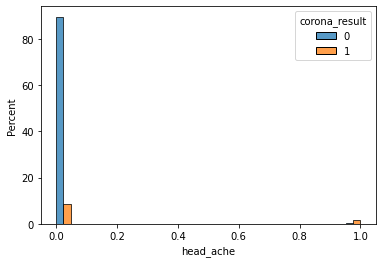

In [36]:
sns.histplot(x='head_ache',hue='corona_result',data=train_df,stat="percent", multiple="dodge")

<AxesSubplot:xlabel='age_60_and_above', ylabel='Percent'>

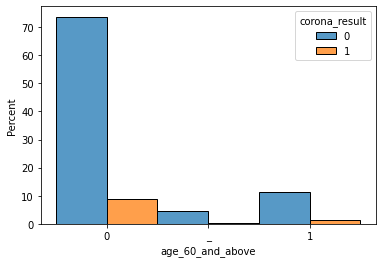

In [37]:
sns.histplot(x='age_60_and_above',hue='corona_result',data=train_df,stat="percent", multiple="dodge")

<AxesSubplot:xlabel='test_indication', ylabel='Percent'>

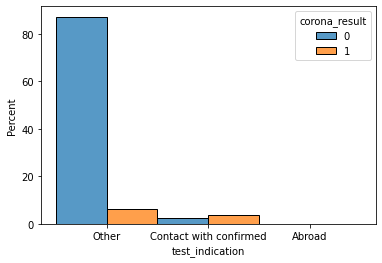

In [38]:
sns.histplot(x='test_indication',hue='corona_result',data=train_df,stat="percent", multiple="dodge")

## Training setup

In [ ]:
train, val = np.split(train_df.sample(frac=1),[int(0.85*len(train_df))])

In [ ]:
val

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop(target)
  #df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  #x = np.asarray(df).astype('float32')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [11]:
batch_size = 16

In [ ]:
full_train_ds = tf.data.experimental.make_csv_dataset(
    train_path,
    batch_size=batch_size,
    label_name='corona_result',
    #num_epochs=1,
    shuffle_buffer_size=100000,
    shuffle_seed = 12,
    ignore_errors=True,
    header=True)

In [12]:
train_ds = tf.data.experimental.make_csv_dataset(
    train_only_path,
    batch_size=batch_size,
    label_name='corona_result',
    num_epochs=1,
    shuffle_buffer_size=100000,
    shuffle_seed = 12,
    ignore_errors=True,
    header=True)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [39]:
val_ds = tf.data.experimental.make_csv_dataset(
    valid_only_path,
    batch_size=batch_size,
    label_name='corona_result',
    num_epochs=1,
    shuffle_buffer_size=100000,
    shuffle_seed = 12,
    ignore_errors=True,
    header=True)

In [40]:
test_ds = tf.data.experimental.make_csv_dataset(
    test_path,
    batch_size=batch_size,
    num_epochs=1,
    shuffle_buffer_size=100000,
    shuffle_seed = 12,
    ignore_errors=True,
    header=True)

In [ ]:
#ds_size =  tf.data.experimental.cardinality(full_train_ds).numpy()
#ds_size = train_size
train_only_size = int(train_split * ds_size)
val_only_size = int(val_split * ds_size)
    
train_only_size, val_only_size

In [ ]:
#train_ds = full_train_ds.take(train_only_size)  
#remaining = full_train_ds.skip(train_only_size)  
#val_ds = remaining.take(val_only_size)

In [41]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['gender'])
print('A batch of targets:', label_batch )

2022-01-26 09:57:19.180967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Every feature: ['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
A batch of ages: tf.Tensor(
[b'female' b'male' b'male' b'male' b'male' b'male' b'male' b'female'
 b'male' b'female' b'female' b'male' b'female' b'male' b'male' b'female'], shape=(16,), dtype=string)
A batch of targets: tf.Tensor([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


## Preprocessing

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [43]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
all_inputs = []
encoded_features = []
categorical_cols = ['gender','test_indication']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)
for header in ['cough',	'fever',	'sore_throat',	'shortness_of_breath',	'head_ache',	'age_60_and_above']:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    all_inputs.append(categorical_col)
    encoded_features.append(categorical_col)

In [44]:
from tensorflow import keras
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

In [45]:
"""
test_date              object
cough                   int64
fever                   int64
sore_throat             int64
shortness_of_breath     int64
head_ache               int64
age_60_and_above       object
gender                 object
test_indication        object
corona_result           int64
dtype: object
"""

# Categorical features encoded as integers
#gender = keras.Input(shape=(1,), name="gender", dtype="int64")
cough = keras.Input(shape=(1,), name="cough", dtype="int64")
fever = keras.Input(shape=(1,), name="fever", dtype="int64")
sore_throat = keras.Input(shape=(1,), name="sore_throat", dtype="int64")
shortness_of_breath = keras.Input(shape=(1,), name="shortness_of_breath", dtype="int64")
head_ache = keras.Input(shape=(1,), name="head_ache", dtype="int64")

# Categorical feature encoded as string
age_60_and_above = keras.Input(shape=(1,), name="age_60_and_above", dtype="string")
gender = keras.Input(shape=(1,), name="gender", dtype="string")
test_indication = keras.Input(shape=(1,), name="test_indication", dtype="string")

all_inputs = [
    cough,
    fever,
    sore_throat,
    shortness_of_breath,
    head_ache,
    age_60_and_above,
    gender,
    test_indication
]

# Integer categorical features
cough_encoded = encode_categorical_feature(cough, "cough", train_ds, False)
fever_encoded = encode_categorical_feature(fever, "fever", train_ds, False)
sore_throat_encoded = encode_categorical_feature(sore_throat, "sore_throat", train_ds, False)
shortness_of_breath_encoded = encode_categorical_feature(shortness_of_breath, "shortness_of_breath", train_ds, False)
#shortness_of_breath_encoded = encode_categorical_feature(shortness_of_breath, "shortness_of_breath", train_ds, False)
head_ache_encoded = encode_categorical_feature(head_ache, "head_ache", train_ds, False)

# String categorical features
age_60_and_above_encoded = encode_categorical_feature(age_60_and_above, "age_60_and_above", train_ds, True)
gender_encoded = encode_categorical_feature(gender, "gender", train_ds, True)
test_indication_encoded = encode_categorical_feature(test_indication, "test_indication", train_ds, True)


all_features = layers.concatenate(
    [
        cough_encoded,
        fever_encoded,
        sore_throat_encoded,
        shortness_of_breath_encoded,
        head_ache_encoded,
        age_60_and_above_encoded,
        gender_encoded,
        test_indication_encoded,
    ]
)


In [46]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [ ]:
all_inputs

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cough (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
fever (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
sore_throat (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
shortness_of_breath (InputLayer [(None, 1)]          0                                            
______________________________________________________________________________________________

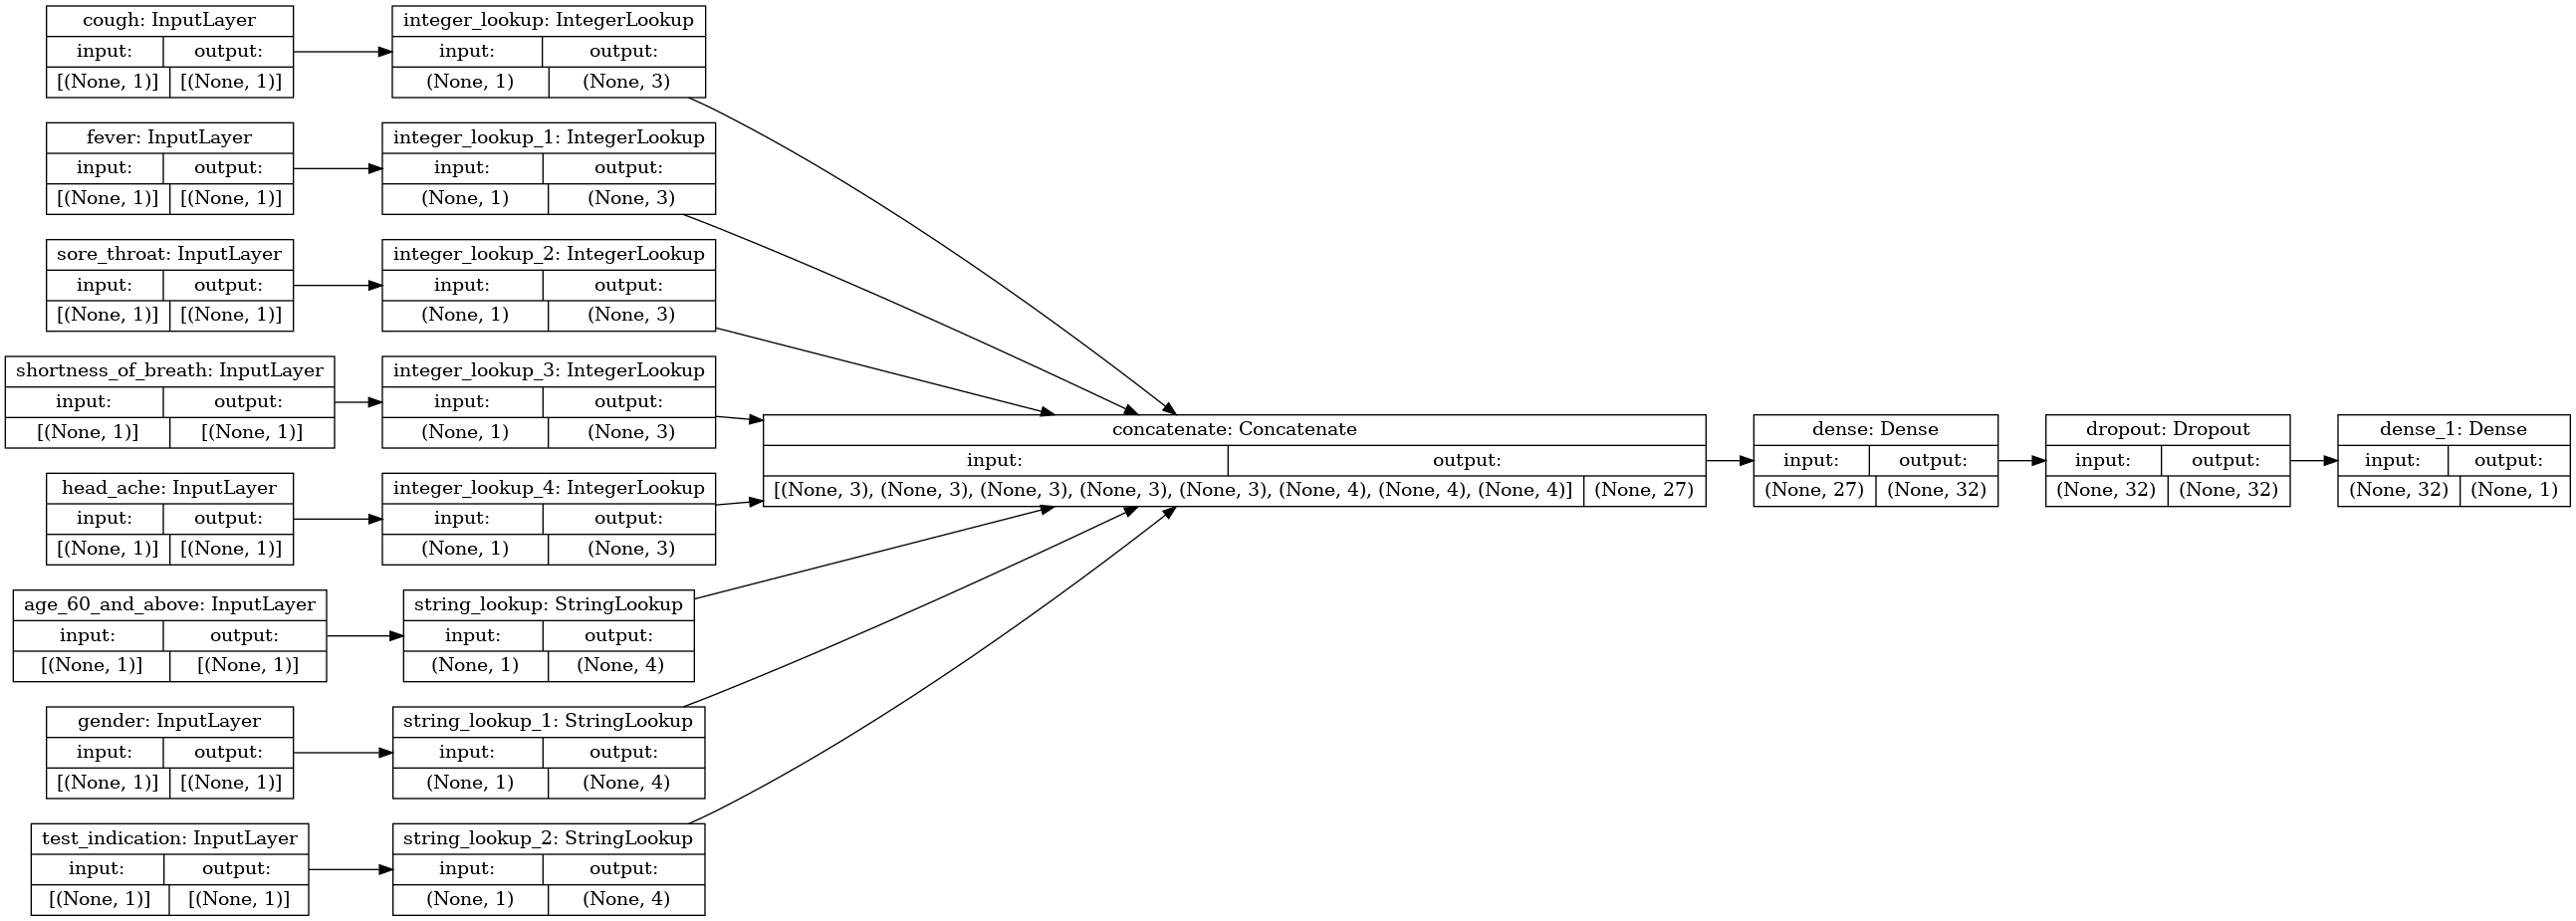

In [48]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
train_ds

In [ ]:
val_ds

In [50]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
46383/46383 [==============================] - 109s 2ms/step - loss: 0.2471 - accuracy: 0.9184 - val_loss: 0.2442 - val_accuracy: 0.9196
Epoch 2/10
46383/46383 [==============================] - 111s 2ms/step - loss: 0.2468 - accuracy: 0.9184 - val_loss: 0.2433 - val_accuracy: 0.9193
Epoch 3/10
46383/46383 [==============================] - 109s 2ms/step - loss: 0.2468 - accuracy: 0.9184 - val_loss: 0.2441 - val_accuracy: 0.9194
Epoch 4/10
46383/46383 [==============================] - 109s 2ms/step - loss: 0.2470 - accuracy: 0.9184 - val_loss: 0.2442 - val_accuracy: 0.9197
Epoch 5/10
46383/46383 [==============================] - 119s 3ms/step - loss: 0.2466 - accuracy: 0.9186 - val_loss: 0.2446 - val_accuracy: 0.9199
Epoch 6/10
46383/46383 [==============================] - 109s 2ms/step - loss: 0.2466 - accuracy: 0.9184 - val_loss: 0.2438 - val_accuracy: 0.9199
Epoch 7/10
46383/46383 [==============================] - 108s 2ms/step - loss: 0.2465 - accuracy: 0.9185 - val_

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cough (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
fever (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
sore_throat (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
shortness_of_breath (InputLayer [(None, 1)]          0                                            
______________________________________________________________________________________________

## Prediction

In [ ]:
test_ds = tf.data.experimental.make_csv_dataset(
    test_path,
    batch_size=16,
    #num_epochs=1,
    shuffle_buffer_size=10000,
    shuffle_seed = 12,
    ignore_errors=True,
    header=True)

In [ ]:
#testing_data['gender'].fillna('unknown')

In [ ]:
#for column in testing_data:
 #   if testing_data[column].isnull().values.any():
  #      print(column)

In [ ]:
#testing_data['gender'] = testing_data['gender'].fillna('None')

In [ ]:
#for column in testing_data:
 #   testing_data[column] = tf.convert_to_tensor(testing_data[column].tolist())

In [ ]:
#testing_data

In [ ]:
#testing_data = test_df.drop(columns=['test_date'])
#testing_data['gender'] = testing_data['gender'].fillna('None')

In [ ]:
#testing_dict = []
#for item in testing_data:
 #   testing_dict.append({name: tf.convert_to_tensor([value]) for name, value in item.items()})
#input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
#predic|tions = reloaded_model.predict(input_dict)
#prob = tf.nn.sigmoid(predictions[0])

In [ ]:
#test_df.drop(columns=['test_date','Index']).reset_index(drop=True).to_dict(orient='records')

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df#.pop(target)
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [52]:
testing_dict = test_df.drop(columns=['test_date','Index']).reset_index(drop=True).to_dict(orient='records')

In [53]:
testing_dict_tensor = []
for item in testing_dict:
    testing_dict_tensor.append({name: tf.convert_to_tensor([value]) for name, value in item.items()})

In [ ]:
predictions = model.predict(testing_dict_tensor)
#prob = tf.nn.sigmoid(predictions[0])

In [1]:
i =0
predictions_labeled = []
for pred in predictions:
    i = i+1
    score = tf.nn.softmax(pred)
    #print(
    #"This image most likely belongs to {} with a {:.2f} percent confidence."
    #.format(classes[np.argmax(score)], 100 * np.max(score)))
    predictions_labeled.append([i,classes[np.argmax(score)].upper()])

NameError: name 'predictions' is not defined

In [ ]:
result = pd.DataFrame(predictions_labeled,columns=['Filename','Label'])
result.to_csv('output.csv',index=False)

In [ ]:
model.save('covid_classifier')

In [ ]:
reloaded_model = tf.keras.models.load_model('covid_classifier')